# PW03 - Group 4
* Florian Bär
* Matthias Egli
* Manuel Vogel
* Adrian Willi

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

Load train and test partition of the MNIST dataset.

Prepare the training by splitting the training partition into a training and validation.

In [2]:
training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

In [3]:
len_data = len(training_data)
len_data

60000

In [4]:
# Partition into train and validate

### YOUR CODE START ###
train_size = int(len_data*0.8)
test_size = len_data-train_size

training_set, validation_set = random_split(training_data,[train_size,test_size ])

### YOUR CODE END ###

### MLP

Implement an MLP model that can be configured with a an arbitrary number of layers and units per layer.

To that end, implement a suitable sub-class of `torch.nn.Module` with a constructor that accepts the following arguments:
* `units`: list of integers that specify the number of units in the different layers. The first element corresponds to the number of units in the input layer (layer '0'), the last element is the number of output units, i.e. the number of classes the classifier is designed for (10 for an MNIST classifier). Hence, MLP will have $n$ hidden layers if `units` has $n+1$ elements. 
* `activation_class`: Class name of the activation function layer to be used (such as `torch.nn.ReLU`). Instances can be created by `activation_class()` and added to the succession of layers defined by the model. 

Alternatively, you can implement a utility method that creates a `torch.nn.Sequential` model accordingly. 


In [5]:
### YOUR CODE START ###

class MLP(torch.nn.Module):
    
    def __init__(self, units, activation_class = None):
        super().__init__()
        self.layers = []
        for i in range(len(units)-2):
            self.layers.append(torch.nn.Linear(units[i], units[i+1]))
            self.layers.append(torch.nn.ReLU())
        self.layers.append(torch.nn.Linear(units[len(units)-2], units[len(units)-1]))
        print([layer for layer in self.layers])
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            *self.layers
        )
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
### YOUR CODE END ###

In [6]:
model = MLP([28*28,300, 100, 10], torch.nn.ReLU)

summary(model, (1,28,28))

[Linear(in_features=784, out_features=300, bias=True), ReLU(), Linear(in_features=300, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=10, bias=True)]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
---------------------------------------------------------

### Training Loop

For training, implement a method with the arguments:
* `model`: Model to be trained
* `lr`: Learning rate
* `nepochs`: Number of epochs
* `batchsize`: Batch size
* `training_data`: Training set (subclassed of `Dataset`)
* `validation_data`: Validation set (subclassed of `Dataset`)

Remember the training and validation cost and accuracy, respectively for monitoring the progress of the training. <br>
Note that for the training cost and accuracy you can use the per batch quantities averaged over an epoch. 

Furthermore, you can use the SGD optimizer of pytorch (`torch.optim.SGD`) - but without momentum.

In [7]:
def train_eval(model, lr, nepochs, nbatch, training_set, validation_set):
    # finally return the sequence of per epoch values
    cost_hist = []
    cost_hist_valid = []
    acc_hist = []
    acc_hist_valid = []

    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    ### YOUR CODE START ###
    
    # epoch: current epoch
    # cost, cost_valid, acc, acc_valid: cost and acurracy (for training, validation set) per epoch     
    
    training_loader = DataLoader(training_set, batch_size=nbatch)
    validation_loader = DataLoader(validation_set, batch_size=nbatch)
    
    for epoch in range(nepochs):

        training_cost = 0
        correct = 0
        for inputs, targets in training_loader:
            optimizer.zero_grad()
            predictions = model(inputs)
            cost = cost_ce(predictions, targets)
            cost.backward()
            optimizer.step()
            training_cost += cost.item()
            correct += (torch.argmax(predictions, dim=1) == targets).sum()
        
        cost = training_cost / len(training_set)
        acc = correct / len(training_set)

        validation_cost = 0
        correct = 0
        for inputs, targets in validation_loader:
            predictions = model(inputs)
            cost = cost_ce(predictions, targets)
            validation_cost += cost.item()
            correct += (torch.argmax(predictions, dim=1) == targets).sum()

        cost_valid = validation_cost / len(validation_set)
        acc_valid = correct / len(validation_set)
        
        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_valid, acc_valid))

        ### YOUR CODE END ###
        
        cost_hist.append(cost.data)
        cost_hist_valid.append(cost_valid)
        acc_hist.append(acc)
        acc_hist_valid.append(acc_valid)
    return cost_hist, cost_hist_valid, acc_hist, acc_hist_valid

### Exploration

Now use this functionality to explore different layer configurations: 
* Number of layers
* Number of units per layer
* Suitable learning rate
* Suitable number of epochs.

Use a batchsize of 64.

Make sure that you choose a sufficinetly large number of epochs so that the learning has more or less stabilizes (converged). 

[Linear(in_features=784, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True)]
Epoch 0: 1.757027, 0.300521, 0.026976, 0.550917
Epoch 1: 0.978262, 0.669500, 0.015861, 0.751000
Epoch 2: 0.698996, 0.777125, 0.011761, 0.802417
Epoch 3: 0.562771, 0.816437, 0.009768, 0.832917
Epoch 4: 0.479396, 0.839521, 0.008544, 0.850917
Epoch 5: 0.423839, 0.853604, 0.007760, 0.862500
Epoch 6: 0.385600, 0.863271, 0.007235, 0.871333
Epoch 7: 0.357817, 0.870938, 0.006864, 0.877083
Epoch 8: 0.336058, 0.876729, 0.006587, 0.881083
Epoch 9: 0.318135, 0.880813, 0.006370, 0.883917
Epoch 10: 0.303113, 0.884917, 0.006195, 0.887917
Epoch 11: 0.289722, 0.888125, 0.006049, 0.890417
Epoch 12: 0.277736, 0.890333, 0.005925, 0.893667
Epoch 13: 0.266421, 0.892979, 0.005817, 0.896667
Epoch 14: 0.256439, 0.894792, 0.005722, 0.897583
Epoch 15: 0.247577, 0.896333, 0.005638, 0.898417
Epoch 16: 0.239628, 0.897937, 0.005563, 0.899750
Epoch 17: 0.232242, 0.899063, 0.005495, 0.901333
Epoch 18: 0.22

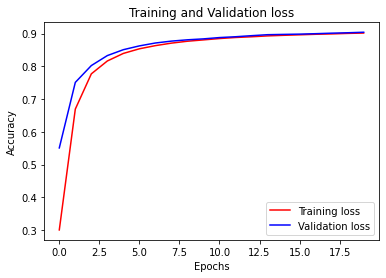

In [8]:
model = MLP([28*28,10, 10])
epochs = 20
lr = 0.005
batch_size = 64
_,_, train_acc, val_acc = train_eval(model, lr, epochs, batch_size, training_set, validation_set)
print(f'train_accuracy {train_acc[-1]}, val_accuracy {val_acc[-1]}')


plt.plot(train_acc, 'r', label='Training loss')
plt.plot(val_acc, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

[Linear(in_features=784, out_features=300, bias=True), ReLU(), Linear(in_features=300, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=10, bias=True)]
Epoch 0: 0.196113, 0.804292, 0.005216, 0.904917
Epoch 1: 0.103797, 0.914896, 0.003944, 0.928667
Epoch 2: 0.066576, 0.935750, 0.003136, 0.945250
Epoch 3: 0.043087, 0.949000, 0.002609, 0.954417
Epoch 4: 0.034451, 0.957187, 0.002269, 0.959917
Epoch 5: 0.029469, 0.964188, 0.002027, 0.963917
Epoch 6: 0.027474, 0.969604, 0.001854, 0.967167
Epoch 7: 0.025282, 0.973437, 0.001719, 0.969500
Epoch 8: 0.023091, 0.976771, 0.001615, 0.971083
Epoch 9: 0.021426, 0.979958, 0.001527, 0.973750
Epoch 10: 0.019480, 0.982063, 0.001461, 0.973833
Epoch 11: 0.017992, 0.984688, 0.001404, 0.974667
Epoch 12: 0.016261, 0.986917, 0.001365, 0.975833
Epoch 13: 0.015978, 0.989042, 0.001334, 0.976167
Epoch 14: 0.015180, 0.990729, 0.001311, 0.976250
Epoch 15: 0.014298, 0.992229, 0.001293, 0.976250
Epoch 16: 0.014304, 0.993521, 0.001282, 0.976667

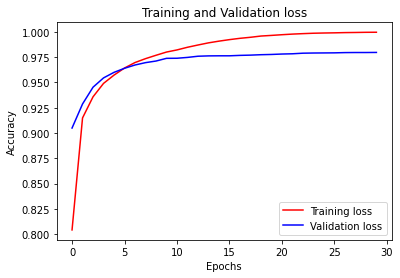

In [9]:
model = MLP([28*28, 300, 100, 10])
epochs = 30
lr = 0.05
batch_size = 64

_,_, train_acc, val_acc = train_eval(model, lr, epochs, batch_size, training_set, validation_set)
print(f'train_accuracy {train_acc[-1]}, val_accuracy {val_acc[-1]}')

plt.plot(train_acc, 'r', label='Training loss')
plt.plot(val_acc, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

[Linear(in_features=784, out_features=500, bias=True), ReLU(), Linear(in_features=500, out_features=300, bias=True), ReLU(), Linear(in_features=300, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=10, bias=True)]
Epoch 0: 0.233672, 0.713583, 0.005623, 0.898250
Epoch 1: 0.101986, 0.911646, 0.003867, 0.931583
Epoch 2: 0.049216, 0.940188, 0.002756, 0.949750
Epoch 3: 0.032252, 0.956125, 0.002208, 0.960250
Epoch 4: 0.026109, 0.966208, 0.001908, 0.965167
Epoch 5: 0.021483, 0.973188, 0.001709, 0.968417
Epoch 6: 0.016757, 0.978625, 0.001575, 0.970667
Epoch 7: 0.012739, 0.982396, 0.001483, 0.972333
Epoch 8: 0.010403, 0.985563, 0.001416, 0.974417
Epoch 9: 0.008302, 0.988979, 0.001376, 0.974167
Epoch 10: 0.006145, 0.991188, 0.001349, 0.974917
Epoch 11: 0.005741, 0.993312, 0.001331, 0.975750
Epoch 12: 0.005050, 0.995188, 0.001326, 0.976750
Epoch 13: 0.004269, 0.996625, 0.001320, 0.977833
Epoch 14: 0.003859, 0.997542, 0.001316, 0.978500
Epoch 15: 0.003576, 0.998333, 0.001

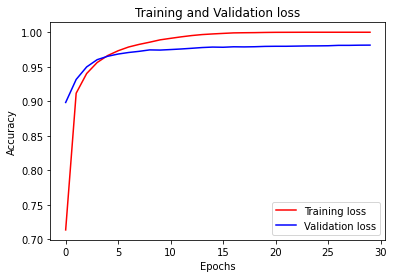

In [10]:
model = MLP([28*28, 500, 300, 100, 10])
epochs = 30
lr = 0.05
batch_size = 64

_,_, train_acc, val_acc = train_eval(model, lr, epochs, batch_size, training_set, validation_set)
print(f'train_accuracy {train_acc[-1]}, val_accuracy {val_acc[-1]}')

plt.plot(train_acc, 'r', label='Training loss')
plt.plot(val_acc, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

[Linear(in_features=784, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=500, bias=True), ReLU(), Linear(in_features=500, out_features=10, bias=True)]
Epoch 0: 0.196945, 0.818583, 0.004989, 0.908417
Epoch 1: 0.123900, 0.916500, 0.003962, 0.929750
Epoch 2: 0.104687, 0.932667, 0.003277, 0.942167
Epoch 3: 0.084131, 0.944792, 0.002782, 0.950333
Epoch 4: 0.071757, 0.953833, 0.002423, 0.956250
Epoch 5: 0.066791, 0.961000, 0.002165, 0.960000
Epoch 6: 0.061000, 0.966354, 0.001979, 0.963667
Epoch 7: 0.055651, 0.971313, 0.001841, 0.967333
Epoch 8: 0.050363, 0.974854, 0.001734, 0.969000
Epoch 9: 0.047595, 0.977667, 0.001646, 0.971500
train_accuracy 0.9776666760444641, val_accuracy 0.9714999794960022


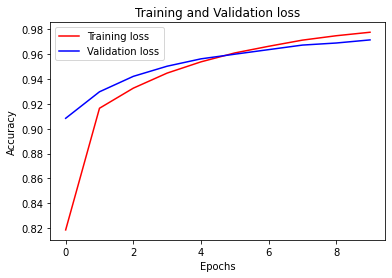

In [11]:
model = MLP([28*28, 100, 500, 10])
epochs = 10
lr = 0.05
batch_size = 64

_,_, train_acc, val_acc = train_eval(model, lr, epochs, batch_size, training_set, validation_set)
print(f'train_accuracy {train_acc[-1]}, val_accuracy {val_acc[-1]}')

plt.plot(train_acc, 'r', label='Training loss')
plt.plot(val_acc, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

[Linear(in_features=784, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=500, bias=True), ReLU(), Linear(in_features=500, out_features=10, bias=True)]
Epoch 0: 0.168602, 0.818250, 0.004938, 0.909250
Epoch 1: 0.105739, 0.917313, 0.003856, 0.931667
Epoch 2: 0.077903, 0.936188, 0.003185, 0.944917
Epoch 3: 0.064013, 0.947521, 0.002738, 0.950750
Epoch 4: 0.057630, 0.955312, 0.002415, 0.956583
Epoch 5: 0.054276, 0.961812, 0.002173, 0.960417
Epoch 6: 0.051280, 0.967438, 0.001985, 0.964000
Epoch 7: 0.047766, 0.971875, 0.001849, 0.967417
Epoch 8: 0.046505, 0.975396, 0.001750, 0.968667
Epoch 9: 0.045038, 0.977917, 0.001672, 0.969750
Epoch 10: 0.041251, 0.979937, 0.001612, 0.971167
Epoch 11: 0.040521, 0.982417, 0.001565, 0.971667
Epoch 12: 0.037669, 0.984146, 0.001537, 0.971583
Epoch 13: 0.036375, 0.986083, 0.001514, 0.972417
Epoch 14: 0.034006, 0.987458, 0.001499, 0.973083
Epoch 15: 0.030679, 0.988792, 0.001491, 0.973333
Epoch 16: 0.029485, 0.990167, 0.001480, 0.973333

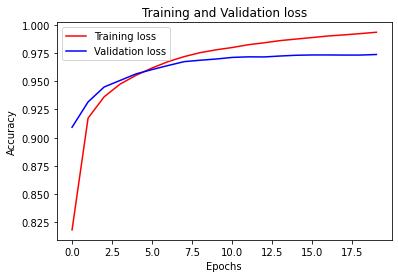

In [12]:
model = MLP([28*28, 100, 500, 10])
epochs = 20
lr = 0.05
batch_size = 64

_,_, train_acc, val_acc = train_eval(model, lr, epochs, batch_size, training_set, validation_set)
print(f'train_accuracy {train_acc[-1]}, val_accuracy {val_acc[-1]}')

plt.plot(train_acc, 'r', label='Training loss')
plt.plot(val_acc, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

[Linear(in_features=784, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), ReLU(), Linear(in_features=50, out_features=10, bias=True)]
Epoch 0: 0.232997, 0.787875, 0.005425, 0.900250
Epoch 1: 0.136152, 0.910792, 0.004238, 0.923417
Epoch 2: 0.086478, 0.930083, 0.003433, 0.939917
Epoch 3: 0.059136, 0.943333, 0.002873, 0.949417
Epoch 4: 0.045253, 0.951937, 0.002504, 0.955417
Epoch 5: 0.038518, 0.958562, 0.002260, 0.960750
Epoch 6: 0.033318, 0.963958, 0.002089, 0.963833
Epoch 7: 0.030897, 0.969000, 0.001951, 0.965500
Epoch 8: 0.028953, 0.972229, 0.001842, 0.967333
Epoch 9: 0.026181, 0.975146, 0.001755, 0.969333
train_accuracy 0.9751458168029785, val_accuracy 0.9693333506584167


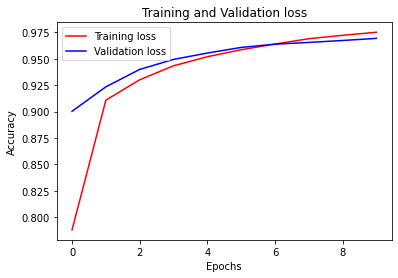

In [13]:
model = MLP([28*28, 100, 50, 10])
epochs = 10
lr = 0.05
batch_size = 64

_,_, train_acc, val_acc = train_eval(model, lr, epochs, batch_size, training_set, validation_set)
print(f'train_accuracy {train_acc[-1]}, val_accuracy {val_acc[-1]}')

plt.plot(train_acc, 'r', label='Training loss')
plt.plot(val_acc, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Summary

Summarize your findings with the different settings in a table

| Units | nepochs | lr | Acc (Train) | Acc (Valid) |
| --- | :-: | :-: | :-: | :-: |
| (784,10,10) | 20 | 0.5 | 94.1% | 93.4% |
| (784,300,100,10) | 10 | 0.05 | 99.9% | 97.7% |
| (784,500,300,100,10) | 30 | 0.005 | 99.9% | 97.8% |
| (784,100,500,10) | 10 | 0.05 | 97.8% | 96.7% |
| (784,100,500,10) | 20 | 0.05 | 99.3%| 97.3% | 
| (784,100,50,10) | 10 | 0.05 | 97.38% | 96.5% |




I prefer the Model with the following attributes (784,100,500,10)  10  0.05    97.8%   96.7%

It does not seem to have such an immense overfit as the last one in the table, i.e. the gap between train and validation loss appears to be smaller.
